# Fashion MNIST

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from PIL import Image

/home/jk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load Data / Data Split

In [ ]:
np.random.seed(2018)
tf.set_random_seed(2018)

In [2]:
###from tensorflow API
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, 

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
y_train_lists = pd.Series(y_train)
y_test_lists = pd.Series(y_test)

In [5]:
y_train_lists.value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
dtype: int64

In [6]:
y_test_lists.value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
dtype: int64

In [7]:
# x_train[0].shape

In [8]:
labels_desc = {"Label":"Description",
0:"T-shirt/top",
1:"Trouser",
2:"Pullover",
3:"Dress",
4:"Coat",
5:"Sandal",
6:"Shirt",
7:"Sneaker",
8:"Bag",
9:"Ankle boot",}

In [9]:
# labels_desc[y_train[0]]

In [10]:
# plt.imshow(x_train[0])
# plt.legend(labels_desc[y_train[0]])
# plt.show()

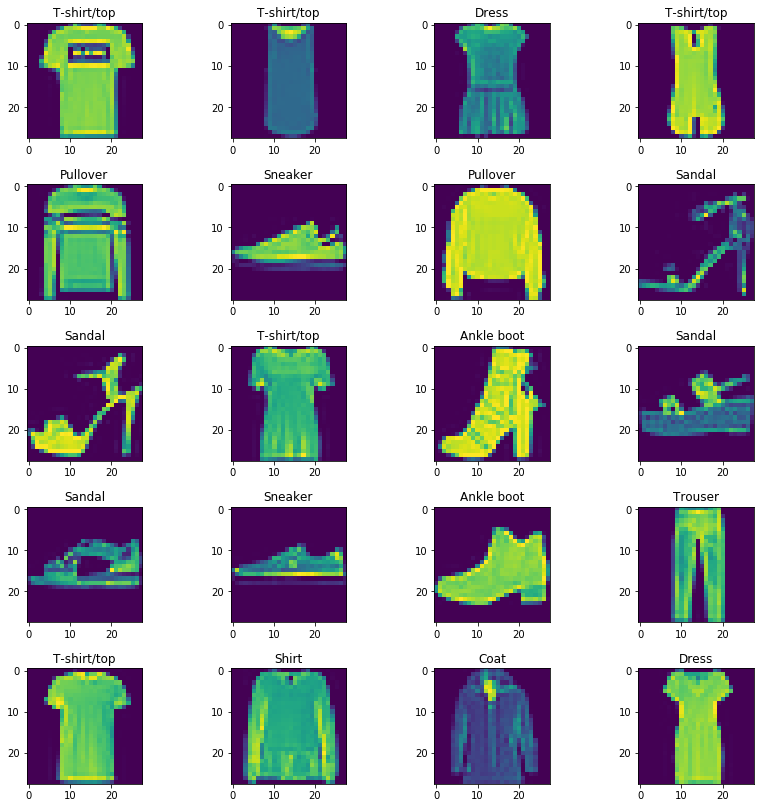

In [11]:
fig=plt.figure(figsize=(14, 14))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
#     img = np.random.randint(10, size=(h,w))
    img = x_train[i]
    fig.add_subplot(rows, columns, i)
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.title(labels_desc[y_train[i]])
    plt.imshow(img)
plt.show()

### Load Tensorflow Slim

In [12]:
slim = tf.contrib.slim
# sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess_config = tf.ConfigProto()

In [13]:
x_train = x_train / 255.
x_train = x_train.astype(dtype = np.float32)
y_train = np.asarray(y_train, dtype=np.int32)

x_test = x_test / 255.
x_test = x_test.astype(np.float32)
y_test = np.asarray(y_test, dtype=np.int32)

In [14]:
# x_train에서 training에 쓸 index 50000개 가져옴
tr_indices = np.random.choice(np.arange(x_train.shape[0]), size = 50000, replace = False)

# model training에 이용할 data
x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices]

# epoch 마다 model validation에 이용할 data
x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0)

print('for training {}, {}'.format(x_tr.shape, y_tr.shape))
print('for validation {}, {}'.format(x_val.shape, y_val.shape))

for training (50000, 28, 28), (50000,)
for validation (10000, 28, 28), (10000,)


In [15]:
batch_size = 32

# for training
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
tr_iterator = tr_dataset.make_initializable_iterator()

print(tr_dataset)

# for validation
# validation data의 용량이 in memory에 넣을 수 없을정도로 아래와 같이 활용한다.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size = 10000)
val_dataset = val_dataset.batch(batch_size = batch_size)
val_iterator = val_dataset.make_initializable_iterator()

print(val_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float32, tf.int32)>


In [16]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string)
iterator = tf.data.Iterator.from_string_handle(handle,
                                               tr_dataset.output_types,
                                               tr_dataset.output_shapes)
x, y = iterator.get_next()

### Model Architecture

In [17]:
def cnn_model_fn(x):
    """"Model function for CNN.
    Args:
        x: input images
        mode: boolean whether trainig mode or test mode
    Returns:
    logits: unnormalized score funtion
  """
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    # MNIST images are 28x28 pixels, and have one color channel

    # batch normalization 적용 여부를 control하기위한 placeholder 
    is_training = tf.placeholder(tf.bool)
    
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 28, 28, 1])
    
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                         weights_regularizer = slim.l2_regularizer(scale = .0003),
                         normalizer_fn = slim.batch_norm,
                         normalizer_params = {'decay' : .9, 'is_training': is_training}):

        conv1 = slim.conv2d(x_image, 32, [5, 5], scope='conv1')
        pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
        conv2 = slim.conv2d(pool1, 64, [5, 5], scope='conv2')
        pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')
        pool2_flat = slim.flatten(pool2, scope='flatten')
        fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')
        logits = slim.fully_connected(fc1, 10, activation_fn=None, normalizer_fn = None,
                                      normalizer_params = None,
                                      scope='logits')
  
    return logits, is_training, x_image

In [18]:
logits, is_training, x_image = cnn_model_fn(x)

In [19]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

# tf.get_collection과 tf.GraphKeys.REGULARIZATION_LOSSES를 이용하여, regularization loss를 가져옴
reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
total_loss = cross_entropy + reg_term

# loss를 계산하기전 training의 경우, mini-batch 당 mean과 variance를 계산해야하고, 
# validation의 경우 training시 mini-batch당 가지고 있던 mean과 variance를 exponential moving average를 이용하여
# average한 것을 가지고 있다가 이용해야함. 아래의 코드가 그 기능을 함
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(control_inputs = update_ops):
    train_step = tf.train.AdamOptimizer(1e-4).minimize(total_loss)

### Model Training

In [21]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# history
tr_hist = []
val_hist = []

# Generate handles of tr_iterator and val_iterator
tr_handle, val_handle = sess.run(fetches = [tr_iterator.string_handle(), val_iterator.string_handle()])

# Train
max_epochs = 4
print('Training Start!!')
total = time.time()
for epoch in range(max_epochs):
    print('Epoch : {}'.format(epoch + 1))
    start = time.time()

    
    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0
    
    # training 1-epoch
    sess.run(tr_iterator.initializer)
    while True:
        try:
            _, tr_loss = sess.run(fetches = [train_step, total_loss],
                                  feed_dict = {handle : tr_handle, is_training : True})
            tr_step += 1
            avg_tr_loss += tr_loss
            if tr_step % 500 == 0:
                print("step: {}, loss: {}".format(tr_step, tr_loss))
                
        except tf.errors.OutOfRangeError:
            break
    
    # validation 1-epoch
    sess.run(val_iterator.initializer)
    while True:
        try:
            val_loss = sess.run(total_loss, 
                                feed_dict = {handle : val_handle, is_training : False})
            val_step += 1
            avg_val_loss += val_loss
            if val_step % 500 == 0:
                print("step: {}, loss: {}".format(val_step, val_loss))
        
        except tf.errors.OutOfRangeError:
            break
            
    avg_tr_loss /= tr_step
    avg_val_loss /= val_step
    tr_hist.append(avg_tr_loss)
    val_hist.append(avg_val_loss)
#     duration  = time.time() - time
    print()
    print('Epochs : {}, Train_loss : {:.3f}, Validation_loss : {:.3f}, Elapsed time : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss, time.time() - start))
    print()
    
print('Training Done!!')
print('Total duration : {:.3f}'.format(time.time() - total))

Training Start!!
Epoch : 1
step: 100, loss: 0.7981196045875549
step: 200, loss: 0.5651634335517883
step: 300, loss: 0.6618705987930298
step: 400, loss: 0.5790042281150818
step: 500, loss: 0.6561180353164673
step: 600, loss: 0.6108473539352417
step: 700, loss: 0.47389093041419983
step: 800, loss: 0.39107975363731384
step: 900, loss: 0.7070994973182678
step: 1000, loss: 0.5472091436386108
step: 1100, loss: 0.6238095760345459
step: 1200, loss: 0.35069283843040466
step: 1300, loss: 0.4145175814628601
step: 1400, loss: 0.4562360942363739
step: 1500, loss: 0.6544031500816345
step: 100, loss: 0.3733886480331421
step: 200, loss: 0.47532179951667786
step: 300, loss: 0.6567791700363159
Epochs :1, Train_loss : 0.605, Validation_loss : 0.513, Elapsed time : 311.195
Epoch : 2
step: 100, loss: 0.5489856004714966
step: 200, loss: 0.4634879529476166
step: 300, loss: 0.4371207058429718
step: 400, loss: 0.5475990772247314
step: 500, loss: 0.5105562210083008
step: 600, loss: 0.4913475513458252
step: 700,

### Validation Model

In [ ]:
yhat = sess.run(logits, feed_dict = {x : x_test, is_training : False})
yhat = np.argmax(yhat, axis = 1)

In [ ]:
print('Test Accuracy : {:.2%}'.format(np.mean(yhat == y_test)))

In [ ]:
plt.plot(tr_hist, label = 'train')
plt.plot(val_hist, label = 'validation')
plt.legend()

# Load Pre-trained model

In [ ]:
# x_train = x_train * 255.
# x_train = x_train.astype(dtype = np.float32)
# y_train = np.asarray(y_train, dtype=np.int32)

# x_test = x_test * 255.
# x_test = x_test.astype(np.float32)
# y_test = np.asarray(y_test, dtype=np.int32)

In [ ]:
slim = tf.contrib.slim
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

In [ ]:
# from tensorflow.contrib.slim.nets import vgg
from nets import vgg

In [ ]:
def vgg_16(inputs, reuse=False, scope='vgg_16'):
    """Oxford Net VGG 16-Layers version D Example
    My Note: This code is modified version of vgg_16 which is loacted on `models/research/slim/nets/vgg.py`
    Note: All the fully_connected layers have been transformed to conv2d layers.
          To use in classification mode, resize input to 224x224.
    Args:
      inputs: a tensor of size [batch_size, height, width, channels].
      reuse: whether or not the model is being reused.
      scope: Optional scope for the variables.
    Returns:
      net: the output of the logits layer (if num_classes is a non-zero integer),
        or the input to the logits layer (if num_classes is 0 or None).
      end_points: a dict of tensors with intermediate activations.
    """
    with tf.variable_scope(scope, 'vgg_16', [inputs], reuse=reuse) as sc:
        end_points_collection = sc.original_name_scope + '_end_points'
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],       # 일단 max 플링으로.
                            outputs_collections=end_points_collection):
            # 여기를 직접 채워 넣으시면 됩니다.
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')

            end_points = slim.utils.convert_collection_to_dict(end_points_collection)

            return net, end_points

In [ ]:
inputs = tf.placeholder(tf.float32, [None, 224, 224, 3])

In [ ]:
with slim.arg_scope(vgg.vgg_arg_scope()):
    outputs, end_points = vgg_16(inputs, reuse = tf.AUTO_REUSE)

In [ ]:
for node in end_points:
    print(node)

In [ ]:
with tf.Session() as sess:
    writer = tf.summary.FileWriter("./graphs/fashion_vgg16", sess.graph)
    writer.close()

In [ ]:
saver = tf.train.Saver()

with tf.Session(config=sess_config) as sess:

    # use saver object to load variables from the saved model
    saver.restore(sess, "vgg_16_ckpt/vgg_16.ckpt")

    # print conv1_1 weight itself
    conv1_1_w = sess.run(tf.trainable_variables()[0])

    # print feature maps
    conv1_1, conv2_1, \
    conv3_2, conv4_3, \
    conv5_3 = sess.run([end_points['vgg_16/conv1/conv1_1'],
                      end_points['vgg_16/conv2/conv2_1'],
                      end_points['vgg_16/conv3/conv3_2'],
                      end_points['vgg_16/conv4/conv4_3'],
                      end_points['vgg_16/conv5/conv5_3']],
                     feed_dict={inputs: my_images})